# Prior

In [8]:
import numpy as np
from matplotlib import pyplot as plt

import os
os.chdir('../../../..')
print(os.getcwd())

from src.smc_2324_project.simulate.generate_dataset import *
from src.smc_2324_project.tempering.base_dist import *
from src.smc_2324_project.tempering.tempering import *

from src.smc_2324_project.variational.posterior_gamma import hessian, sample_from_gamma
from src.smc_2324_project.variational.posterior_nu import sample_from_nu
from src.smc_2324_project.variational.SBM_regression import VEM

c:\Users\Paul\Documents\X


In [3]:
# hyperparameters
n, k, p = 40, 3, 4
gamma_0 = np.array([0.6,0.6,0.6,1, 0, 3, 1.1, 2.2, 0.1, -0.3])
V_0 = np.eye(len(gamma_0))
e_0 = 3 * np.ones(k)

# prior
theta_prior = define_theta_prior(gamma_0, V_0, e_0)
prior = define_prior(theta_prior, n)

# Dataset

In [5]:
# generate dataset
alpha, beta, nu = generate_network_params(k, gamma_0, V_0, e_0)
X = generate_covariates(n, p)
sample_from_network((alpha, beta, nu), X)
theta = (alpha,beta,nu)
Y, Z = sample_from_network(theta,X, return_Z=True)

# VEM inference

In [11]:
# VEM
particle = prior.rvs()[0]
gamma_init, nu_init = particle["theta"]["gamma"], particle["theta"]["nu"]
tau_init = np.array([nu for i in range(n)])
inferred_gamma, inferred_nu, inferred_tau = VEM(Y, X, gamma_init, nu_init, tau_init)
hess = hessian(Y, X, inferred_tau, inferred_gamma)

number of iterations: 15
terminal gamma, nu: (array([-1.17499011e+00, -1.17664275e+00, -1.17634420e+00, -1.17659386e+00,
       -1.17656164e+00, -1.17657832e+00, -5.61846657e-01,  5.10654938e-01,
        2.75807015e-05, -1.71989050e+00]), array([0.22286257, 0.77713743, 0.        ]))


In [12]:
# posterior distribution
e_tilde = e_0 + np.sum(inferred_tau,axis=0)
invV0 = np.linalg.inv(V_0)
cov_gamma = np.linalg.inv((invV0 - hess))
mean_gamma = cov_gamma @ (invV0 @ gamma_0 - hess @ inferred_gamma)

In [13]:
# relaxation
relaxation = 0.4
cov_gamma = (1-relaxation) * cov_gamma + relaxation * np.eye(len(gamma_0))
e_tilde = (1-relaxation) * e_tilde + relaxation * e_0
inferred_nu = (1-relaxation) * inferred_nu + relaxation * nu

In [14]:
# base_dist
base_dist = define_VEM_base_dist(inferred_tau, inferred_nu, mean_gamma, cov_gamma)

In [15]:
# debug
sample = base_dist.rvs()
assert base_dist.logpdf(sample) < 0 # not necessarily true, but should be true most of the time

c:\Users\Paul\Documents\X\4A\S1\HMM\poisson_network_models\src\smc_2324_project\tempering\base_dist.py:18: RuntimeWarning: divide by zero encountered in log
  lp = np.log(self.p)


# Logtarget and model

In [16]:
# target
compute_llh_target = define_llh_target(prior, X, Y, k)

In [17]:
from particles.smc_samplers import TemperingBridge

class ToyBridge(TemperingBridge):
    def logtarget(self, theta):
        return compute_llh_target(theta)

In [18]:
toy_bridge = ToyBridge(base_dist=base_dist)

# Move

In [19]:
move = FixedLenMCMCSequence(mcmc=CustomGibbs(k, e_0, e_tilde), len_chain=5)

# AdaptiveTempering

In [20]:
import particles

# finally
fk_tpr = FlexibeAdaptiveTempering(model=toy_bridge, len_chain=100, 
                                  move=move, wastefree=False,
                                  tempering_step_size = 0.5) # tempering_step_size = 1-tau_1
alg = particles.SMC(fk=fk_tpr, N=200, ESSrmin=0.8,
                    store_history=True, verbose=True)
alg.run()

t=0, ESS=100.00, tempering exponent=0.000706


c:\Users\Paul\Documents\X\4A\S1\HMM\poisson_network_models\src\smc_2324_project\tempering\base_dist.py:18: RuntimeWarning: divide by zero encountered in log
  lp = np.log(self.p)
c:\Users\Paul\.conda\envs\hmm\Lib\site-packages\particles\smc_samplers.py:851: RuntimeWarning: invalid value encountered in add
  x.lpost = x.lprior + epn * x.llik


t=1, Metropolis acc. rate (over 1 steps): 0.065, ESS=100.00, tempering exponent=0.00272
t=2, Metropolis acc. rate (over 1 steps): 0.095, ESS=100.00, tempering exponent=0.00679
t=3, Metropolis acc. rate (over 1 steps): 0.065, ESS=100.00, tempering exponent=0.0176
t=4, Metropolis acc. rate (over 1 steps): 0.070, ESS=100.00, tempering exponent=0.0371
t=5, Metropolis acc. rate (over 1 steps): 0.030, ESS=100.00, tempering exponent=0.0636
t=6, Metropolis acc. rate (over 1 steps): 0.035, ESS=100.00, tempering exponent=0.0954
t=7, Metropolis acc. rate (over 1 steps): 0.045, ESS=100.00, tempering exponent=0.13
t=8, Metropolis acc. rate (over 1 steps): 0.020, ESS=100.00, tempering exponent=0.191
t=9, Metropolis acc. rate (over 1 steps): 0.005, ESS=100.00, tempering exponent=0.294
t=10, Metropolis acc. rate (over 1 steps): 0.005, ESS=100.00, tempering exponent=0.459
t=11, Metropolis acc. rate (over 1 steps): 0.015, ESS=100.00, tempering exponent=0.673
t=12, Metropolis acc. rate (over 1 steps): 0.

# Plot

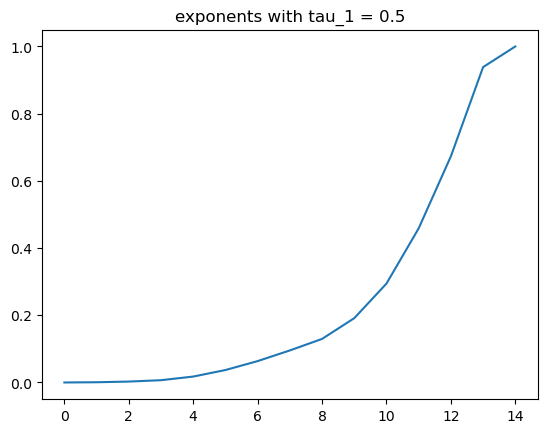

In [21]:
# exponents
exponents = alg.X.shared["exponents"]
plt.plot(exponents)
plt.title("exponents with tau_1 = 0.5")
plt.show()

IndexError: list index out of range

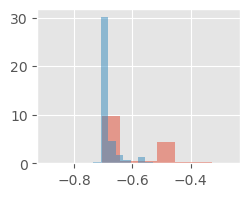

In [25]:
# beta distribution
plt.style.use('ggplot')
fig = plt.figure(figsize=(12, 2))
num_exponents = len(exponents)
for beta_idx in range(4):
    plt.subplot(1, 4, beta_idx+1)
    for t in [num_exponents//2, int(3/4*num_exponents), num_exponents-1]:
        beta_i = alg.hist.X[t].theta["theta"]["gamma"][:,k*(k+1)//2+beta_idx]
        weights = alg.hist.wgts[t].W
        plt.hist(beta_i, weights=weights, label="t=%i" % t, 
                 alpha=0.5, density=True)
    plt.xlabel(beta_idx)
plt.legend()

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [14]:
Z = linkage(Y, 'ward')
d = dendrogram(Z)

In [42]:
res = [(d['leaves'][i], int(d['leaves_color_list'][i][-1])) for i in range(n)]
tau = np.zeros((n, k))
for i, r in enumerate(res):
    tau[i, r[1]-1] = 1

In [47]:
np.sum(Y, axis=0)

array([19., 11., 10.])

In [48]:
np.sum(tau, axis=0)

array([19., 10., 11.])